This notebook is for exploratory analysis of COVID-19 Radiography database from Kaggle : https://www.kaggle.com/tawsifurrahman/covid19-radiography-datab
ase


In [ ]:
import os
import random
from collections import defaultdict
from glob import glob
from math import pi
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from joblib import Parallel, delayed
from skimage.feature import graycomatrix, graycoprops
from tqdm.auto import tqdm
from IPython.display import HTML, display

# CHEMINS ET CHARGEMENT DES DONNEES

## CHEMINS

In [ ]:
# @title VARIABLES DE SESSION
# @markdown
DATA_ROOT = "../data"  # @param {type: "string"}
# @markdown ---

In [ ]:
DATA_ROOT = Path(DATA_ROOT)
RAW_DATA = DATA_ROOT / "01_raw/COVID-19_Radiography_Dataset"
REPS = ["COVID", "Lung_Opacity", "Viral Pneumonia", "Normal"]

In [ ]:
# TODO (Done): taille des images, canaux, nombre,
# TODO (All): Tester l'environnement de travail
# TODO (Yeyecodes): Appliquer les masques et refaire haraclick, moyenne des pixels,
# TODO (Yeyecodes & CedrickArmel): interprétation Haralickpuis
# TODO (TaxelleT & CedrickArmel): calculer l'aire des poumons. Gauche versus droite
# TODO (CedrickArmel): Explorer si la maladie ne concerne qu'une seule partie du poumon.
# TODO (CedrickArmel): équilibrer les classes, normaliser , rétirer les outlines, mettre les masques,
# TODO (TaxelleT & CedrickArmel): Appliquer pour mettre en évidence les files, cables

# TODO: data augmentation pour gérer les conditions de prise de vue
# TODO: Appliquer pour mettre en évidence les files, cables

## CHARGEMENT DES DONNES

In [ ]:
metadata = pd.concat(
    [pd.read_excel(file) for file in glob(os.path.join(RAW_DATA, "*.metadata.xlsx"))]
)
metadata.columns = ["file_name", "format", "size", "url"]

In [ ]:
images = defaultdict()
masks: defaultdict = defaultdict()
textures = defaultdict()

In [ ]:
print(
    f"Unique files format in `{RAW_DATA}` subfolders :",
    set([Path(f).suffix for f in glob(str(RAW_DATA / "**/**/*"))]),
)

Unique files format in `../data/01_raw/COVID-19_Radiography_Dataset` subfolders : {'.png'}


> All files in the subfolders of `RAW_DATA` are PNG images.

In [ ]:
clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(32, 32))

In [ ]:
for rep in REPS:
    images[rep.lower().replace(" ", "_")] = [
        cv2.imread(f, cv2.IMREAD_GRAYSCALE)
        for f in glob(str(RAW_DATA / rep / "images/*.png"))
    ]

    masks[rep.lower().replace(" ", "_")] = [
        cv2.imread(f, cv2.IMREAD_GRAYSCALE)
        for f in glob(str(RAW_DATA / rep / "masks/*.png"))
    ]

In [ ]:
for p in glob(str(DATA_ROOT / "00_textures/*.tiff")):
    textures[Path(p).stem] = cv2.imread(p, cv2.IMREAD_GRAYSCALE)

Par exemple pour accéder aux images de la catégorie COVID, faire:
```python
covid_images: list[np.ndarray] = images["covid"]
```
`cv2.IMREAD_GRAYSCALE` pour charger les images en niveaux de gris (une seule bande).

# EXPLORATION DES DONNEES

## EDA

### Analyse des métadonnées

In [ ]:
for key, imgs in images.items():
    images_size = set([img.shape for img in imgs])
    mask_size = set([img.shape for img in masks[key]])
    print(f"{key.replace('_', ' ').upper()}")
    print("\tNombre d'images : ", len(imgs))
    print("\tNombre de masques : ", len(masks[key]))
    print("\tTailles d'images : ", list(images_size))
    print("\tTailles de masques : ", list(mask_size), "\n")

COVID
	Nombre d'images :  3616
	Nombre de masques :  3616
	Tailles d'images :  [(299, 299)]
	Tailles de masques :  [(256, 256)] 

LUNG OPACITY
	Nombre d'images :  6012
	Nombre de masques :  6012
	Tailles d'images :  [(299, 299)]
	Tailles de masques :  [(256, 256)] 

VIRAL PNEUMONIA
	Nombre d'images :  1345
	Nombre de masques :  1345
	Tailles d'images :  [(299, 299)]
	Tailles de masques :  [(256, 256)] 

NORMAL
	Nombre d'images :  10192
	Nombre de masques :  10192
	Tailles d'images :  [(299, 299)]
	Tailles de masques :  [(256, 256)] 



In [ ]:
metadata.head()

,file_name,format,size,url
0,Lung_Opacity-1,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
1,Lung_Opacity-2,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
2,Lung_Opacity-3,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
3,Lung_Opacity-4,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
4,Lung_Opacity-5,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...


In [ ]:
metadata["health_status"] = metadata.file_name.apply(lambda x: x.split("-")[0])
metadata["is_healthy"] = metadata.file_name.apply(
    lambda x: "Sain" if "normal" in x.lower() else "Malade"
)

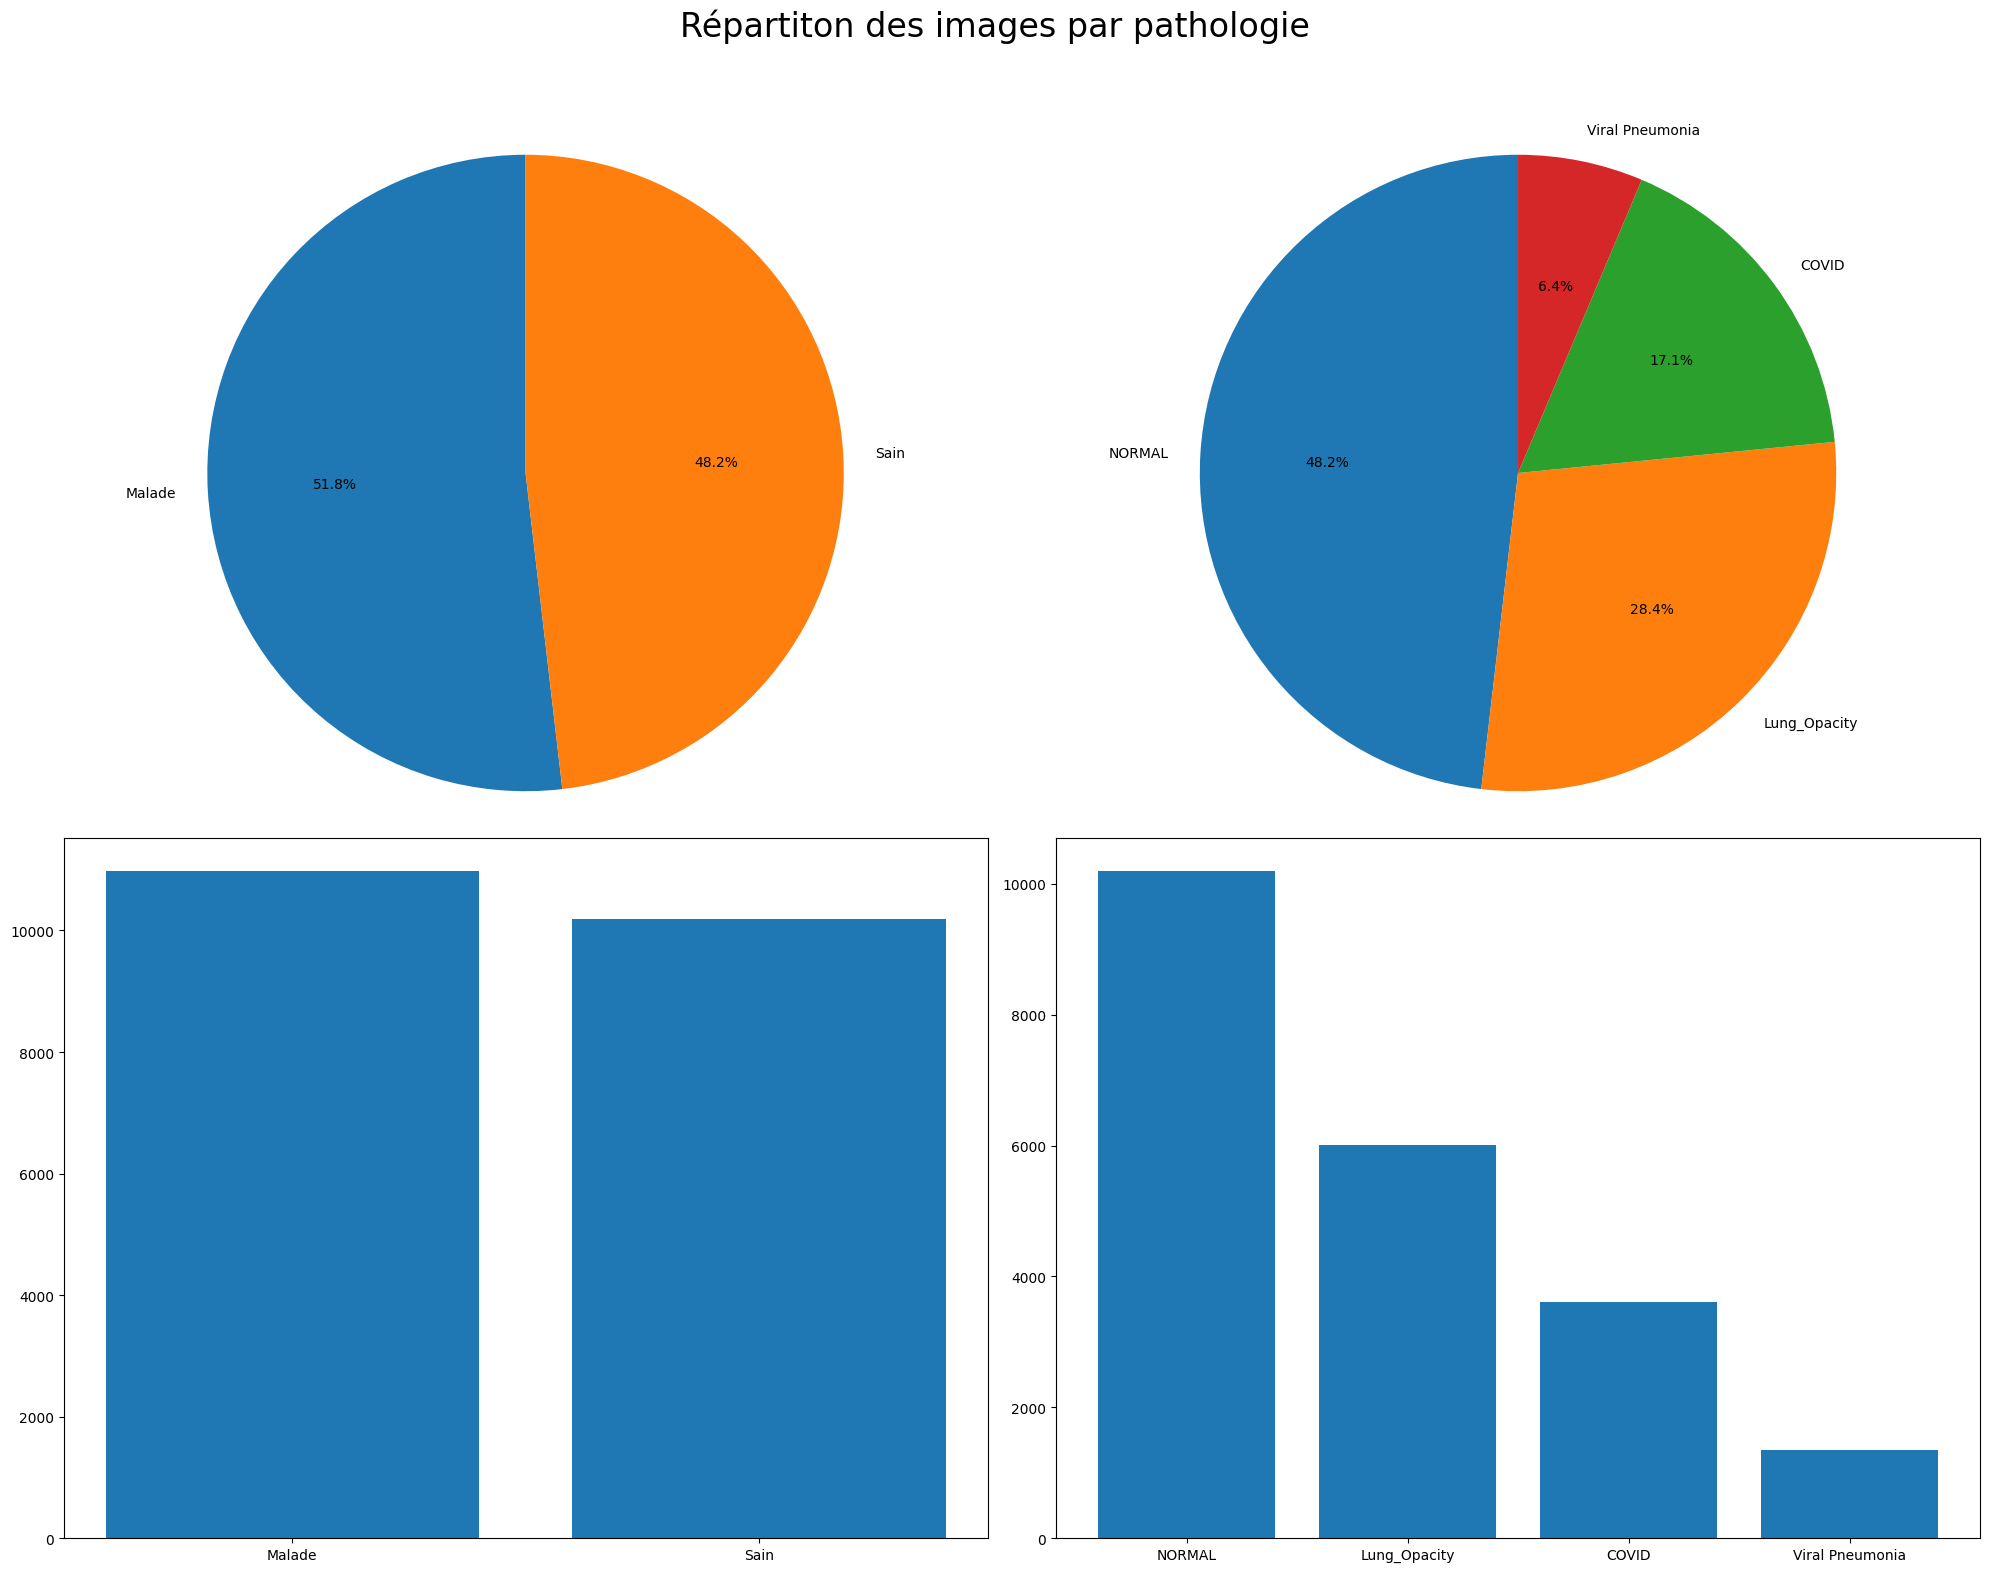

In [ ]:
hs_counts = metadata.health_status.value_counts()
ih_counts = metadata.is_healthy.value_counts()

fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.flatten()
axes[0].pie(ih_counts.values, labels=ih_counts.index, autopct="%1.1f%%", startangle=90)
axes[0].axis("equal")
axes[2].bar(height=ih_counts.values, x=ih_counts.index)

axes[1].pie(hs_counts.values, labels=hs_counts.index, autopct="%1.1f%%", startangle=90)
axes[1].axis("equal")
axes[3].bar(height=hs_counts.values, x=hs_counts.index)
fig.suptitle("Répartiton des images par pathologie", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Images de poumons sains

In [ ]:
poumon_face = cv2.imread(
    "/Users/drxc/Dev/py/sep25_alt1_mle_ds_covid1/references/anatomie_poumon.png.webp",
    cv2.IMREAD_GRAYSCALE,
)
poumon_profil = cv2.imread(
    "/Users/drxc/Dev/py/sep25_alt1_mle_ds_covid1/references/anatomie_poumon_profil.png.webp",
    cv2.IMREAD_GRAYSCALE,
)

(np.float64(-0.5), np.float64(799.5), np.float64(878.5), np.float64(-0.5))

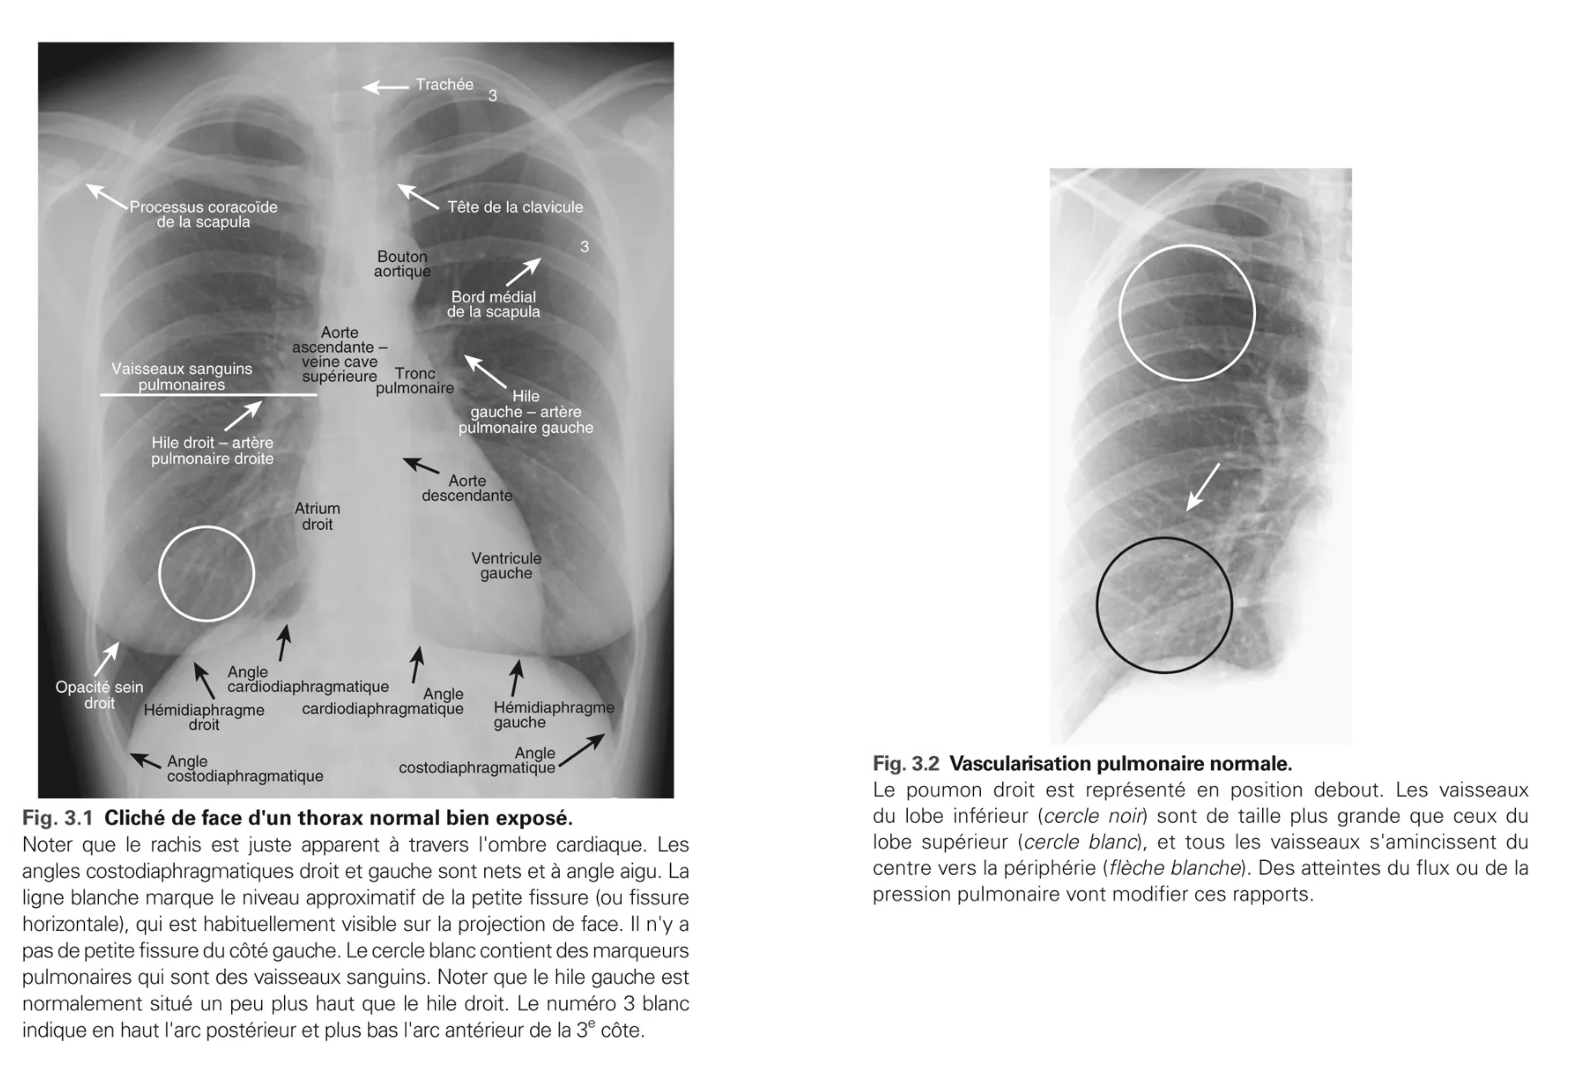

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 20))
axes = axes.flatten()
axes[0].imshow(poumon_face, cmap="gray")
axes[1].imshow(poumon_profil, cmap="gray")
axes[0].axis("off")
axes[1].axis("off")

(np.float64(-0.5), np.float64(799.5), np.float64(878.5), np.float64(-0.5))

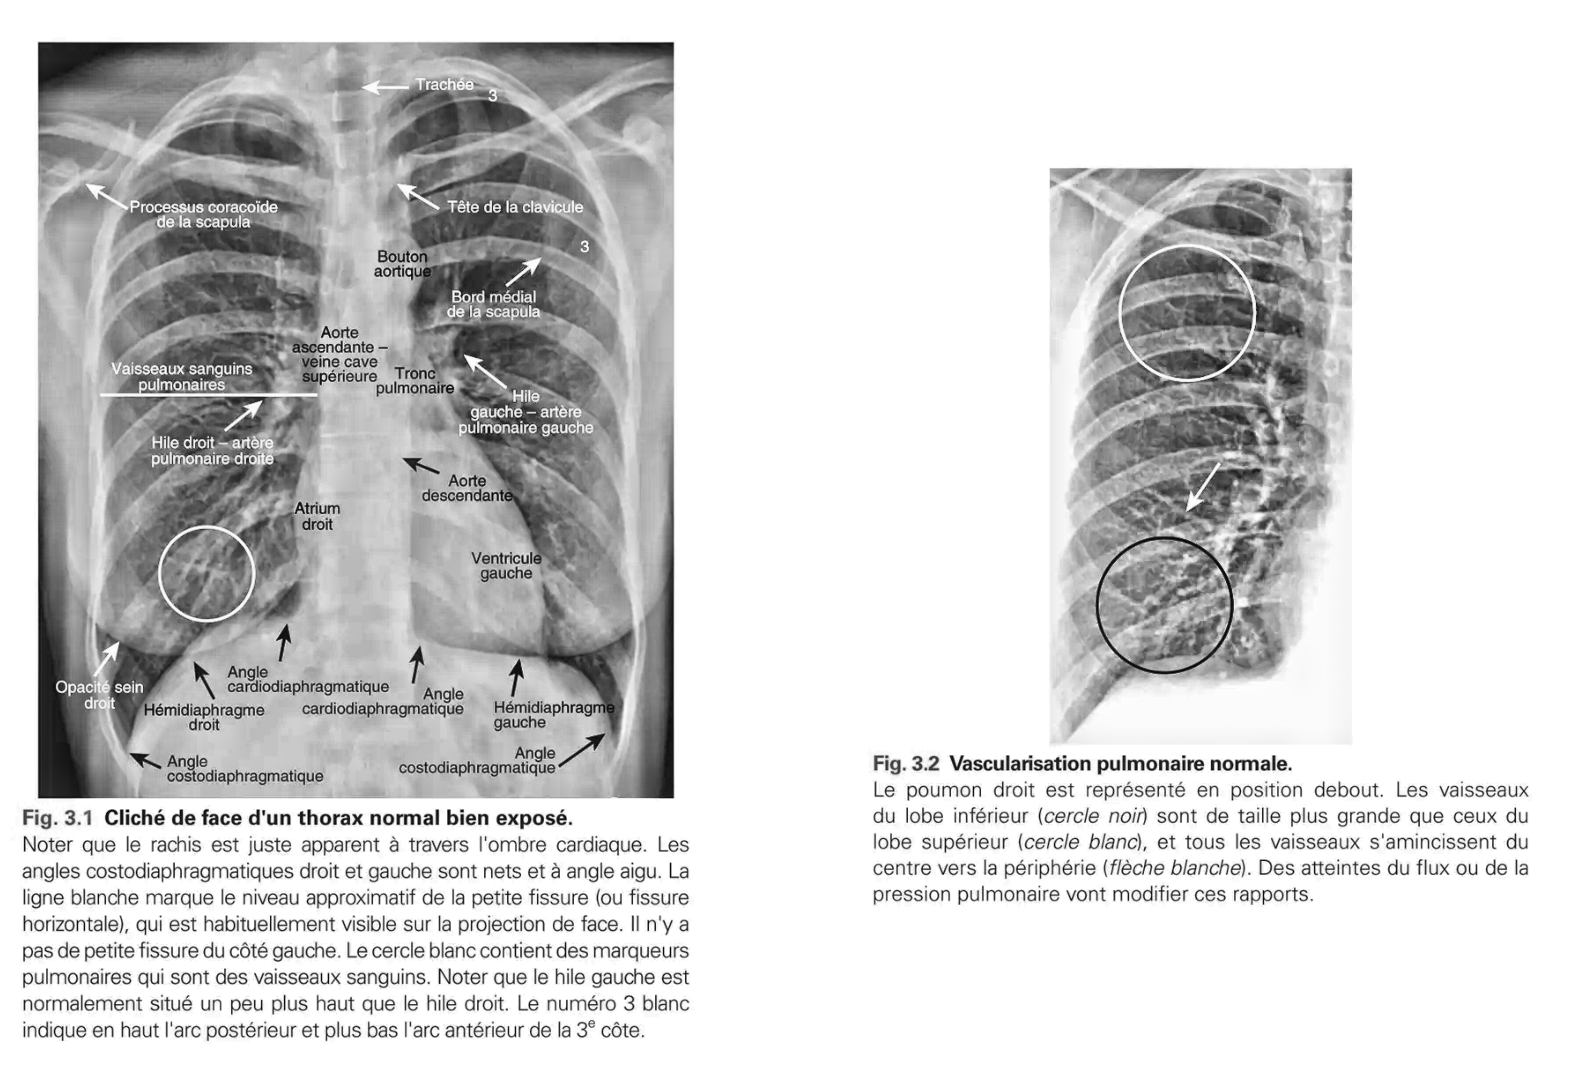

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 20))
axes = axes.flatten()
axes[0].imshow(clahe.apply(poumon_face), cmap="gray")
axes[1].imshow(clahe.apply(poumon_profil), cmap="gray")
axes[0].axis("off")
axes[1].axis("off")

### Visualisation des images

In [ ]:
def make_caption(
    caption: str, org: tuple[int, int] = (10, 28), size: tuple[int, int] = (40, 256)
):
    bg = np.zeros(size, dtype=np.uint8)
    cap = cv2.putText(
        bg, caption, org, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 255, 2, cv2.LINE_AA
    )
    return cap

```python
for rep in REPS:
    # imgs = sorted(glob(str(RAW_DATA / rep / "images/*.png")))
    # msks = sorted(glob(str(RAW_DATA / rep / "masks/*.png")))
    imgpath = glob(str(RAW_DATA / rep / "images/*.png"))
    maskpath = [str(RAW_DATA / rep / "masks" / f"{Path(img).name}") for img in imgpath]

    files = zip(imgpath, maskpath)
    
    ctrstout = DATA_ROOT / "00_clips" / f"{rep.lower()}_contrast_clip.mp4"
    ctrstmskdoutput = DATA_ROOT / "00_clips" / f"{rep.lower()}_masked_contrast_clip.mp4"
    mskdoutput = DATA_ROOT / "00_clips" / f"{rep.lower()}_masked_clip.mp4"
    
    fps = 5

    fourcc = cv2.VideoWriter_fourcc(*"H264")

    ctrstwriter = cv2.VideoWriter(ctrstout, fourcc, fps, (256*2, 256 + 40), isColor=False)
    ctrstmskdwriter = cv2.VideoWriter(ctrstmskdoutput, fourcc, fps, (256*2, 256 + 40), isColor=False)
    mskdwriter = cv2.VideoWriter(mskdoutput, fourcc, fps, (256*2, 256 + 40), isColor=False)

    assert ctrstwriter.isOpened(), "CTRST VideoWriter non ouvert"
    assert ctrstmskdwriter.isOpened(), "CTRSTMSKD VideoWriter non ouvert"
    assert mskdwriter.isOpened(), "MSKD VideoWriter non ouvert"

    for i, m in files:
        imgray = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
        ctrstgray = clahe.apply(imgray)
        
        imgray = cv2.resize(imgray, (256, 256), interpolation=cv2.INTER_AREA)
        ctrstgray = cv2.resize(ctrstgray, (256, 256), interpolation=cv2.INTER_AREA)
        
        msk = cv2.imread(m, cv2.IMREAD_GRAYSCALE) 
        
        mskdgray = (msk > 0) * imgray
        ctrstmskdgray = (msk > 0) * ctrstgray
        
        ctrstwriter.write(cv2.vconcat([make_caption(Path(i).stem, size=(40, 256 * 2)), cv2.hconcat([imgray, ctrstgray])]))
        ctrstmskdwriter.write(cv2.vconcat([make_caption(Path(i).stem, size=(40, 256 *2)), cv2.hconcat([ctrstgray, ctrstmskdgray])]))
        mskdwriter.write(cv2.vconcat([make_caption(Path(i).stem, size=(40, 256 * 2)), cv2.hconcat([imgray, mskdgray])]))

    ctrstwriter.release()
    ctrstmskdwriter.release()
    mskdwriter.release()
```

In [ ]:
display(
    HTML(
        """
<script>
function pauseAll() {
  document.querySelectorAll("video").forEach(v => v.pause());
}
function playAll() {
  document.querySelectorAll("video").forEach(v => v.play());
}
</script>

<div style="
  display:grid;
  grid-template-columns: repeat(2, 1fr);
  gap:10px;
  justify-items:center;
  align-items:start;
">

  <!-- NORMAL -->
  <div style="text-align:center;">
    <div style="display:flex; gap:10px;">
      <video muted playsinline loop style="width:auto;height:auto">
        <source src="../data/00_clips/normal_contrast_clip.mp4" type="video/mp4">
      </video>
    </div>
    <p style="margin-top:6px; font-weight:bold;">NORMAL</p>
  </div>

  <!-- COVID -->
  <div style="text-align:center;">
    <div style="display:flex; gap:10px;">
      <video muted playsinline loop style="width:auto;height:auto">
        <source src="../data/00_clips/covid_contrast_clip.mp4" type="video/mp4">
      </video>
    </div>
    <p style="margin-top:6px; font-weight:bold;">COVID</p>
  </div>

  <!-- LUNG OPACITY -->
  <div style="text-align:center;">
    <div style="display:flex; gap:10px;">
      <video muted playsinline loop style="width:auto;height:auto">
        <source src="../data/00_clips/lung_opacity_contrast_clip.mp4" type="video/mp4">
      </video>
    </div>
    <p style="margin-top:6px; font-weight:bold;">LUNG OPACITY</p>
  </div>

  <!-- VIRAL PNEUMONIA -->
  <div style="text-align:center;">
    <div style="display:flex; gap:10px;">
      <video muted playsinline loop style="width:auto;height:auto">
        <source src="../data/00_clips/viral pneumonia_contrast_clip.mp4" type="video/mp4">
      </video>
    </div>
    <p style="margin-top:6px; font-weight:bold;">VIRAL PNEU.</p>
  </div>
</div>
             
<div style="margin-bottom:15px; text-align:center;">
  <button onclick="playAll()">▶️</button>
  <button onclick="pauseAll()" style="margin-right:10px;">⏸</button>
</div>      
"""
    )
)

In [ ]:
display(
    HTML(
        """
<script>
function pauseAll() {
  document.querySelectorAll("video").forEach(v => v.pause());
}
function playAll() {
  document.querySelectorAll("video").forEach(v => v.play());
}
</script>

<div style="
  display:grid;
  grid-template-columns: repeat(2, 1fr);
  gap:10px;
  justify-items:center;
  align-items:start;
">

  <!-- NORMAL -->
  <div style="text-align:center;">
    <div style="display:flex; gap:10px;">
      <video muted playsinline loop style="width:auto;height:auto">
        <source src="../data/00_clips/normal_masked_clip.mp4" type="video/mp4">
      </video>
    </div>
    <p style="margin-top:6px; font-weight:bold;">NORMAL</p>
  </div>

  <!-- COVID -->
  <div style="text-align:center;">
    <div style="display:flex; gap:10px;">
      <video muted playsinline loop style="width:auto;height:auto">
        <source src="../data/00_clips/covid_masked_clip.mp4" type="video/mp4">
      </video>
    </div>
    <p style="margin-top:6px; font-weight:bold;">COVID</p>
  </div>

  <!-- LUNG OPACITY -->
  <div style="text-align:center;">
    <div style="display:flex; gap:10px;">
      <video muted playsinline loop style="width:auto;height:auto">
        <source src="../data/00_clips/lung_opacity_masked_clip.mp4" type="video/mp4">
      </video>
    </div>
    <p style="margin-top:6px; font-weight:bold;">LUNG OPACITY</p>
  </div>

  <!-- VIRAL PNEUMONIA -->
  <div style="text-align:center;">
    <div style="display:flex; gap:10px;">
      <video muted playsinline loop style="width:auto;height:auto">
        <source src="../data/00_clips/viral pneumonia_masked_clip.mp4" type="video/mp4">
      </video>
    </div>
    <p style="margin-top:6px; font-weight:bold;">VIRAL PNEU.</p>
  </div>
</div>
             
<div style="margin-bottom:15px; text-align:center;">
  <button onclick="playAll()">▶️</button>
  <button onclick="pauseAll()" style="margin-right:10px;">⏸</button>
</div>      
"""
    )
)

**NORNAL**: Poumons entièrement visible en augmentant le contraste; Vascularisation plus régulière; Opacité ne va pas au delà de celles des organes masquants (semble t-il); cables moins fréquents.
**COVID** : alvéoles plus prononcées; vascularisation beaucoup moins régulière; Opacité diffuse et au-delà des organes masquants; cables; 
**LO**: Même contrasté zone blanches; vascularisation moins régulières - groupuscules plus éloignée de l'axe médian (comme dans les autres radio pathologiques)
**VP**: Vasculration irrégulière; zones de concentation loin de l'axe médian

Vascularisation plus dense dans les radiologie pathologiques. Cause potentielle de radiologies plus blanche et moins contrastés (opacité)
Selon la taille, la masse, le sexe on observe plus ou moins de d'opacité.
Différents zoom observées

Les masques du dataset ne détourent pas correctement les poumons comme on peut l'observer sur les images dont on a augmenté le contraste.

In [ ]:
display(
    HTML(
        """
<script>
function pauseAll() {
  document.querySelectorAll("video").forEach(v => v.pause());
}
function playAll() {
  document.querySelectorAll("video").forEach(v => v.play());
}
</script>

<div style="
  display:grid;
  grid-template-columns: repeat(2, 1fr);
  gap:10px;
  justify-items:center;
  align-items:start;
">

  <!-- NORMAL -->
  <div style="text-align:center;">
    <div style="display:flex; gap:10px;">
      <video muted playsinline loop style="width:auto;height:auto">
        <source src="../data/00_clips/normal_masked_contrast_clip.mp4" type="video/mp4">
      </video>
    </div>
    <p style="margin-top:6px; font-weight:bold;">NORMAL</p>
  </div>

  <!-- COVID -->
  <div style="text-align:center;">
    <div style="display:flex; gap:10px;">
      <video muted playsinline loop style="width:auto;height:auto">
        <source src="../data/00_clips/covid_masked_contrast_clip.mp4" type="video/mp4">
      </video>
    </div>
    <p style="margin-top:6px; font-weight:bold;">COVID</p>
  </div>

  <!-- LUNG OPACITY -->
  <div style="text-align:center;">
    <div style="display:flex; gap:10px;">
      <video muted playsinline loop style="width:auto;height:auto">
        <source src="../data/00_clips/lung_opacity_masked_contrast_clip.mp4" type="video/mp4">
      </video>
    </div>
    <p style="margin-top:6px; font-weight:bold;">LUNG OPACITY</p>
  </div>

  <!-- VIRAL PNEUMONIA -->
  <div style="text-align:center;">
    <div style="display:flex; gap:10px;">
      <video muted playsinline loop style="width:auto;height:auto">
        <source src="../data/00_clips/viral pneumonia_masked_contrast_clip.mp4" type="video/mp4">
      </video>
    </div>
    <p style="margin-top:6px; font-weight:bold;">VIRAL PNEU.</p>
  </div>
</div>
             
<div style="margin-bottom:15px; text-align:center;">
  <button onclick="playAll()">▶️</button>
  <button onclick="pauseAll()" style="margin-right:10px;">⏸</button>
</div>      
"""
    )
)

**NORNAL**: Dans la majorité des cas, observation conforme à ce qui est attendu: amincissement des vaisceaux du centre vers la périphérie: Structures claires plus fines dans les poumons sains. structures plus `régulières.`
**SAINS**: Modifications des rapports: Hiles plus étendues, épaisses, vascularisation plus accentué, présence d'agrégats dans des zones périphériques, Opacités orientée du bas vers le haut, avec l'impression que c'est induit par une vascularisation plus épaisse.
    **COVID** : Agrégats; Vascularisation épaisse irrégulière; opacité (du moins mosaiques/motis blanc.he.s)
    **LO**: Opacité diffuse (très souvent orienté bas vers le haut; lobes plus souvent atteints) visible sur image originale non contrasté; Vascularisation épaisse irrégulière
    **VP** : Agrégats; Vascularisation épaisse irrégulière; opacité (du moins mosaiques/motis blanc.he.s)

- Parasites: Cables; Physiologie du patient (âge, masse, seins, etc.)
- L'augmentation du contraste révèle quasi entièrement la structure du poumon
- Vascularisation plus dense dans les radiologie pathologiques. Cause potentielle de radiologies plus blanche et moins contrastés (opacité)
- Selon la taille, la masse, le sexe on observe plus ou moins de d'opacité dans l'image entière.
- Différents zoom observées
- Les masques du dataset ne détourent pas correctement les poumons comme on peut l'observer sur les images dont on a augmenté le contraste.
- Prédonimance du blanc dans le bas des Radio

## ANALYSE TEXTURALES DES IMAGES

La texture d’une image désigne la structure spatiale de l’intensité de luminosité des pixels, qui se répète périodiquement sur l’ensemble de l’image ou sur certaines de ses parties, et qui caractérise la nature de l’image.

Analyser la texture d'une image consiste à essayer de découvrir les motifs qui se repètent et de les extraire sous forme d'une valeur numérique. Répéter cet exercie évolutif à l'échelle de tout notre jeu de données peut nous permettre d'identifier les motifs caractéristiques de chaque catégorie d'images et des biais potentiels.

Plusieurs méthode existent pour analyser la texture d'une image, mais pour cette analyse nous faisons le choix arbitraire d'appliquer une approche qui se base sur la matrice de co-occurence des niveaux de gris ou *Gray-Level Cooccurence Matrix (GLCM)*\[[1](https://colab.research.google.com/drive/1Lntxtu_EDeoG5Rv8eux6W-FDcxn8oZFv#scrollTo=CriYcJt1oZTx&line=5&uniqifier=1)\].

Pour une image avec 256 niveaux de gris, la matrice de co-occurence GLCM est de taille 256 x 256.

Chaque cellule de la matrice de co-occurence GLCM de coordonées $(x, y)$ représente le nombre de fois le niveau de gris $x$ a été observé sous une relation $d$ avec le niveau $y$ dans cette image.

La GLCM est un opérateur statistique et probabiliste qui permet d'extraire des statistiques d'une image qui peuvent représenter sa texture. Ces statistiques dites de Haralick sont: moyenne, variance, entropie, contraste, dissimilarité, homogeneité, ASM, énergie et corrélation.


## CALCUL DES CARACTERISTIQUES DE HARALICK

In [ ]:
def single_image_haralick(
    img: np.array, features: list, distances: list[int], angles: np.array
) -> dict[str, np.array]:
    """Computes a set of Haralick features for a single image."""
    glcm = graycomatrix(
        img, distances=distances, angles=angles, symmetric=True, normed=True
    )  # calcul de la GLCM
    result = {}
    for ft in features:
        props = graycoprops(glcm, prop=ft)  # Calcul des statistiques de Haralick
        result[ft] = props
    return result

Dans la cellule ci-dessus, les arguments `distances` (distance en pixels entre $x$ et $y$) et `angles` (direction en radians de $y$ par rapport à $x$), de la fonction `graycomatrix` de calcul de la GLCM, constituent la relation $d$ entre $x$ et $y$.

A partir de la GLCM, `graycoprops` calcule successivement les caractéristiques de Haralick suivantes:

*   **Moyenne (mean)** : $\sum_{i=0}^{levels-1} i*P_{i}$

La moyenne représente le niveau global d’intensité des régions mises en relation. Des valeurs plus élevées indiquent une prédominance de zones claires, tandis que des valeurs plus faibles correspondent à une dominance de zones sombres.

*   **Ecart-type (std)** : $\sqrt{variance} = \sqrt{\sum_{i=0}^{levels-1} P_{i}*(i-mean)^2}$

L’écart-type mesure l’amplitude des fluctuations d’intensité autour de la moyenne. Une valeur élevée traduit une alternance marquée entre zones claires et zones sombres, tandis qu’une valeur faible indique une distribution plus uniforme.

*   **Entropie (entropy)** : $\sum_{i,j=0}^{levels-1} -P_{i,j}*log(P_{i,j})$

L'entropie quantifie le degré de désordre ou de complexité de la distribution des co-occurrences.

Une entropie élevée traduit une grande diversité de relations entre niveaux de gris, correspondant à une organisation spatiale complexe et peu redondante des intensités. À l’inverse, une entropie faible indique une structure plus régulière, dominée par un nombre restreint de motifs d’intensité.

*   **Contraste (contrast)**: $\sum_{i,j=0}^{levels-1} P_{i,j}(i-j)^2$

Le contraste pondère les co-occurrences par le carré de la différence d’intensité.

Un contraste élevé indique la présence de transitions marquées entre zones sombres et zones claires, tandis qu’un contraste faible correspond à des variations d’intensité plus progressives et homogènes.

*   **Homogénéité (homogeneity)** : $\sum_{i,j=0}^{levels-1}\frac{P_{i,j}}{1+(i-j)^2}$

Cette caractéristique privilégie les co-occurrences proches de la diagonale $i = j$ et prend des valeurs élevées lorsque les variations d’intensité locales sont faibles ou nulles.

*   **Energie (energy)** : $\sqrt{ASM} = \sqrt{\sum_{i,j=0}^{levels-1}P_{i,j}}$

L’énergie mesure la concentration de la distribution des co-occurrences.

Des valeurs élevées d’énergie indiquent que les relations d’intensité sont dominées par quelques couples de niveaux de gris, ce qui correspond à des motifs répétitifs et réguliers. Une énergie faible reflète une dispersion plus large des co-occurrences, associée à une structure plus hétérogène.

*   **Corrélation (correlation)** : $\sum_{i,j=0}^{levels-1} P_{i,j}\left[\frac{(i-\mu_i)
(j-\mu_j)}{\sqrt{(\sigma_i^2)(\sigma_j^2)}}\right]$

Une corrélation proche de 0 indique une indépendance statistique entre les niveaux de gris des pixels considérés, tandis qu’une valeur élevée traduit une dépendance linéaire forte.

Mais il est également de calculer ces caractéristiques que nous laissons délibérément de côté car elles apportent des informations similaires à celles calculés:
*   **Dissimilarité (dissimilarity)** : $\sum_{i,j=0}^{levels-1}P_{i,j}|i-j|$ similaire au contraste.
*   **ASM**, voir énergie
*   **Variance**, voir écart-type.


In [ ]:
def compute_haralick_parallel(
    images: list[np.ndarray],
    features: list,
    distances: list[int],
    angles: np.array,
    n_jobs: int = -1,
    verbose=1,
) -> list[dict]:
    """Computes a set of Haralick features for a set of images in parallel using joblib."""
    results = Parallel(n_jobs=n_jobs, verbose=verbose)(
        delayed(single_image_haralick)(img, features, distances, angles)
        for img in images
    )
    return results

In [ ]:
DMAX = 29
HARALICK_FEATURES = [
    "mean",
    "std",
    "entropy",
    "contrast",
    "homogeneity",
    "energy",
    "correlation",
]
ANGLES = (np.pi / 4) * np.arange(0, 4)  # angles in rad from 0 to pi
DIRECTIONS = {"horizontal": 0, "diagonal1": 1, "vertical": 2, "diagonal2": 3}

In [ ]:
haralick_features = defaultdict(lambda: defaultdict(lambda: np.empty((DMAX, 0))))

In [ ]:
textures_haralick = compute_haralick_parallel(
    textures.values(), HARALICK_FEATURES, range(DMAX), ANGLES
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:    5.8s finished


```python
for rep, pool in tqdm(images.items()):
  results = compute_haralick_parallel(pool, HARALICK_FEATURES, range(DMAX), ANGLES)
  for r in results:
    for ft in HARALICK_FEATURES:
      haralick_features[ft][rep] = np.concat([haralick_features[ft][rep], r[ft]], axis=1)
```

```python
for rep in images.keys():
  for ft in HARALICK_FEATURES:
         np.save(file=PROJECT_ROOT/f"data/00_dumps/haralick_features_{ft}_{rep}.npy", arr=haralick_features[ft][rep], allow_pickle=False)
```

Ci-dessous nous important directement les données précalculées (voir `Markdown`ci-dessus) de textures depuis le dossier Drive du projet.

In [ ]:
for rep in images.keys():
    for ft in HARALICK_FEATURES:
        haralick_features[ft][rep] = np.load(
            DATA_ROOT / f"00_dumps/haralick_features_{ft}_{rep}.npy"
        )

## VISUALIZATION ET ANALYSE

### VISUALIZATION

In [ ]:
def display_haralick(
    d: str,
    directions: dict[str, int],
    haralick_features: dict[str, dict],
    ncols: int = 2,
):
    nrows = np.ceil(len(haralick_features) / ncols).astype(int)
    fig, axes = plt.subplots(nrows, ncols, figsize=(20, nrows * 4))
    axes = axes.flatten()
    for i, ft in enumerate(haralick_features):
        for rep in haralick_features[ft].keys():
            axes[i].plot(
                np.mean(haralick_features[ft][rep][:, directions[d] :: 4], axis=1),
                label=f"{rep.upper()}",
            )
        axes[i].set_title(ft.capitalize())
        # axes[i].legend(title="Health Status")

    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        title="Health Status",
        loc="center right",
        bbox_to_anchor=(0.98, 0.3),
    )
    fig.suptitle(
        f"Caractéristique de Haralick selon la direction {d.capitalize() if 'diagonal' not in d else 'Diagonal'} - {directions[d] * 45}°",
        fontsize=16,
    )
    fig.supxlabel("Distance entre $x$ et $y$", fontsize=14)
    fig.supylabel("Valeur des caractéristiques", fontsize=14, x=0)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.tight_layout()
    plt.show()

In [ ]:
def display_texture_sample(
    name: str,
    texture: np.ndarray,
    features: dict[str, dict],
    d: str,
    directions: dict[str, int],
    ncols: int = 2,
):
    nrows = np.ceil((len(features) + 1) / ncols).astype(int)
    fig, axes = plt.subplots(nrows, 4, figsize=(20, nrows * 4))
    axes = axes.flatten()
    axes[0].imshow(texture, cmap="gray")
    axes[0].set_title("Texture")
    axes[0].axis("off")
    for i, ft in enumerate(features):
        axes[i + 1].plot(features[ft][:, directions[d] :: 4])
        axes[i + 1].set_title(ft.capitalize())

    for j in range(i + 2, len(axes)):
        axes[j].axis("off")

    fig.suptitle(
        f"Carac. de Haralick de la texture {name} - Direction {d.capitalize() if 'diagonal' not in d else 'Diagonal'} - {directions[d] * 45}°",
        fontsize=16,
    )

    fig.supxlabel("Distance entre $x$ et $y$", fontsize=14)
    fig.supylabel("Valeur des caractéristiques", fontsize=14, x=0)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.tight_layout()
    plt.show()

In [ ]:
def boxplot_all_haralick(haralick_features: dict[str, dict[str, np.ndarray]]) -> None:
    """Plots the computed Haralick's features box-plots.

    Args:
        haralick_features (dict[str, dict[str, np.ndarray]]): Haralick's features for all images.
    """
    features = list(haralick_features.keys())
    categories = list(next(iter(haralick_features.values())).keys())

    data_list = []
    for ft in features:
        for rep in categories:
            values = np.mean(haralick_features[ft][rep], axis=0)
            for v in values:
                data_list.append(
                    {"Feature": ft.capitalize(), "Category": rep.upper(), "Value": v}
                )

    df_plot = pd.DataFrame(data_list)

    plt.figure(figsize=(18, 6))
    sns.boxplot(x="Feature", y="Value", hue="Category", data=df_plot)
    plt.title("Distribution des features Haralick par catégorie")
    plt.ylabel("Valeur moyenne de la feature")
    plt.xlabel("Feature")
    plt.xticks(rotation=45)
    plt.legend(title="Catégorie")
    plt.tight_layout()
    plt.show()

In [ ]:
def heatmap_haralick_all(haralick_features: dict[str, dict[str, np.ndarray]]) -> None:
    """Plots the computed Haralick's features correlation heatmap.

    Args:
        haralick_features (dict[str, dict[str, np.ndarray]]): Haralick's features for all images.
    """
    for rep in next(iter(haralick_features.values())).keys():
        df = pd.DataFrame(
            {
                ft: np.mean(haralick_features[ft][rep], axis=0)
                for ft in haralick_features
            }
        )
        corr = df.corr()
        plt.figure(figsize=(8, 6))
        sns.heatmap(
            corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1, fmt=".2f", square=True
        )
        plt.title(
            f"Corrélation entre features Haralick – {' '.join(rep.split('_')).upper()}"
        )
        plt.tight_layout()
        plt.show()

In [ ]:
def radar_all_haralick(haralick_features: dict[str, dict[str, np.ndarray]]) -> None:
    """Plots the computed Haralick's features radar.

    Args:
        haralick_features (dict[str, dict[str, np.ndarray]]): Haralick's features for all images.
    """
    features = list(haralick_features.keys())
    reps = haralick_features[features[0]].keys()

    N = len(features)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, polar=True)

    for rep in reps:
        values = [np.mean(haralick_features[ft][rep]) for ft in features]
        values += values[:1]
        ax.plot(angles, values, linewidth=2, label=" ".join(rep.split("_")).upper())
        ax.fill(angles, values, alpha=0.15)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features, fontsize=11)
    ax.set_title("Radar chart – Signatures des textures Haralick", fontsize=11)
    ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
    plt.show()

#### Avant normalisation des images

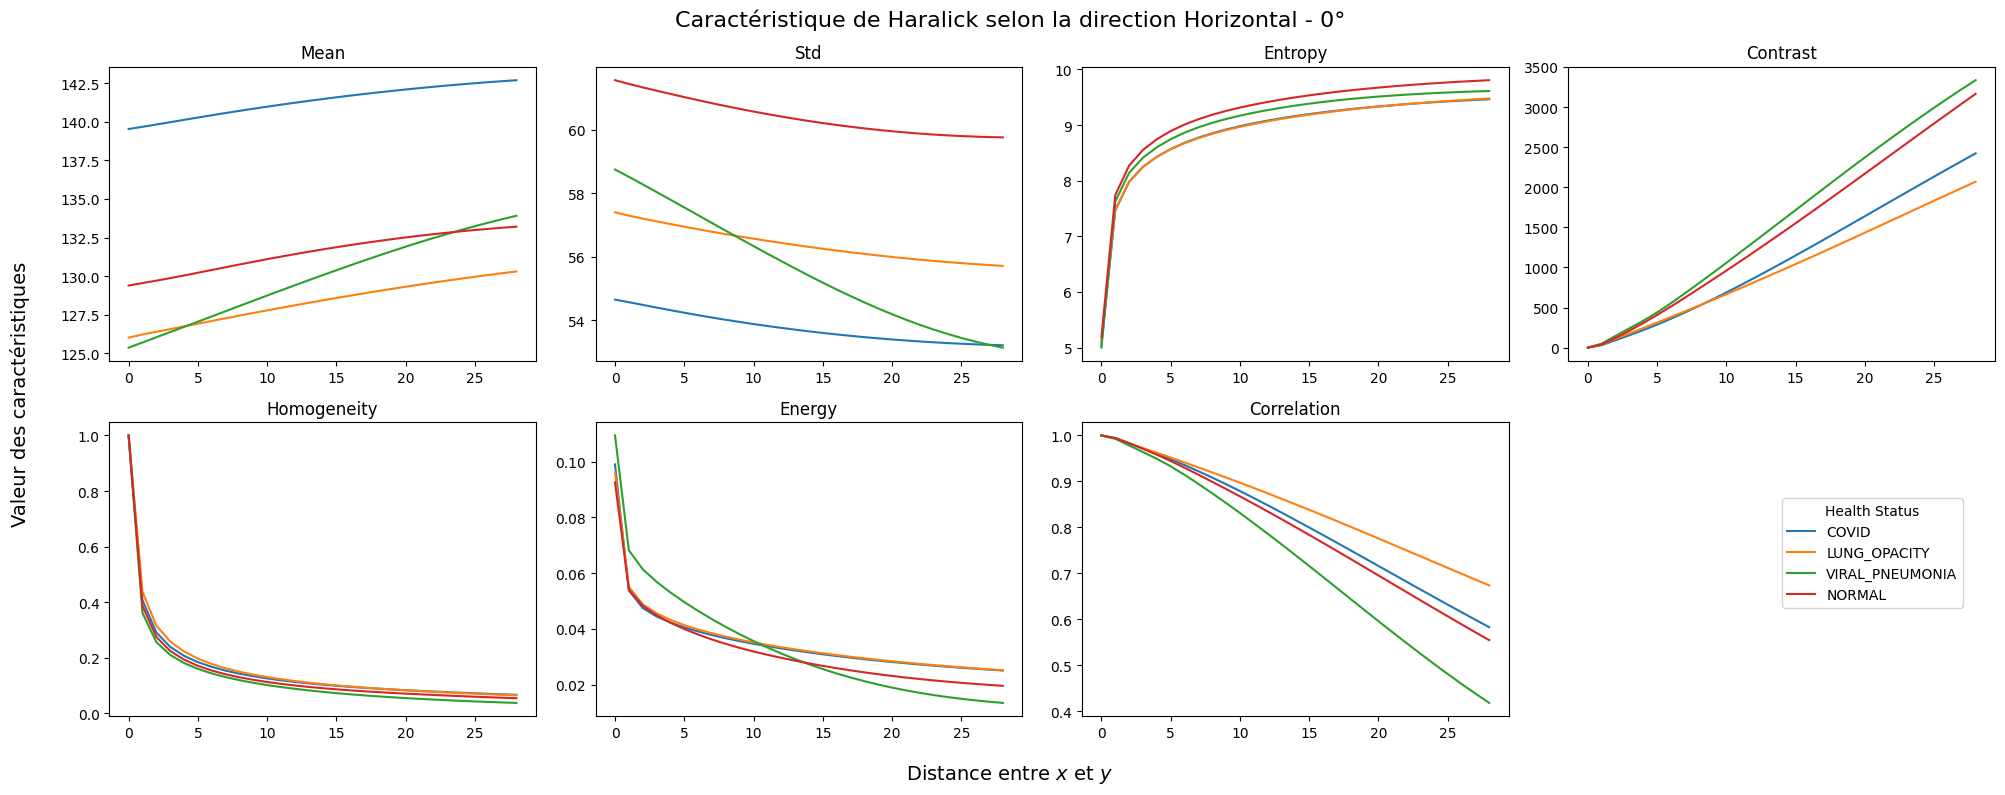

In [ ]:
display_haralick(
    d="horizontal", directions=DIRECTIONS, haralick_features=haralick_features, ncols=4
)

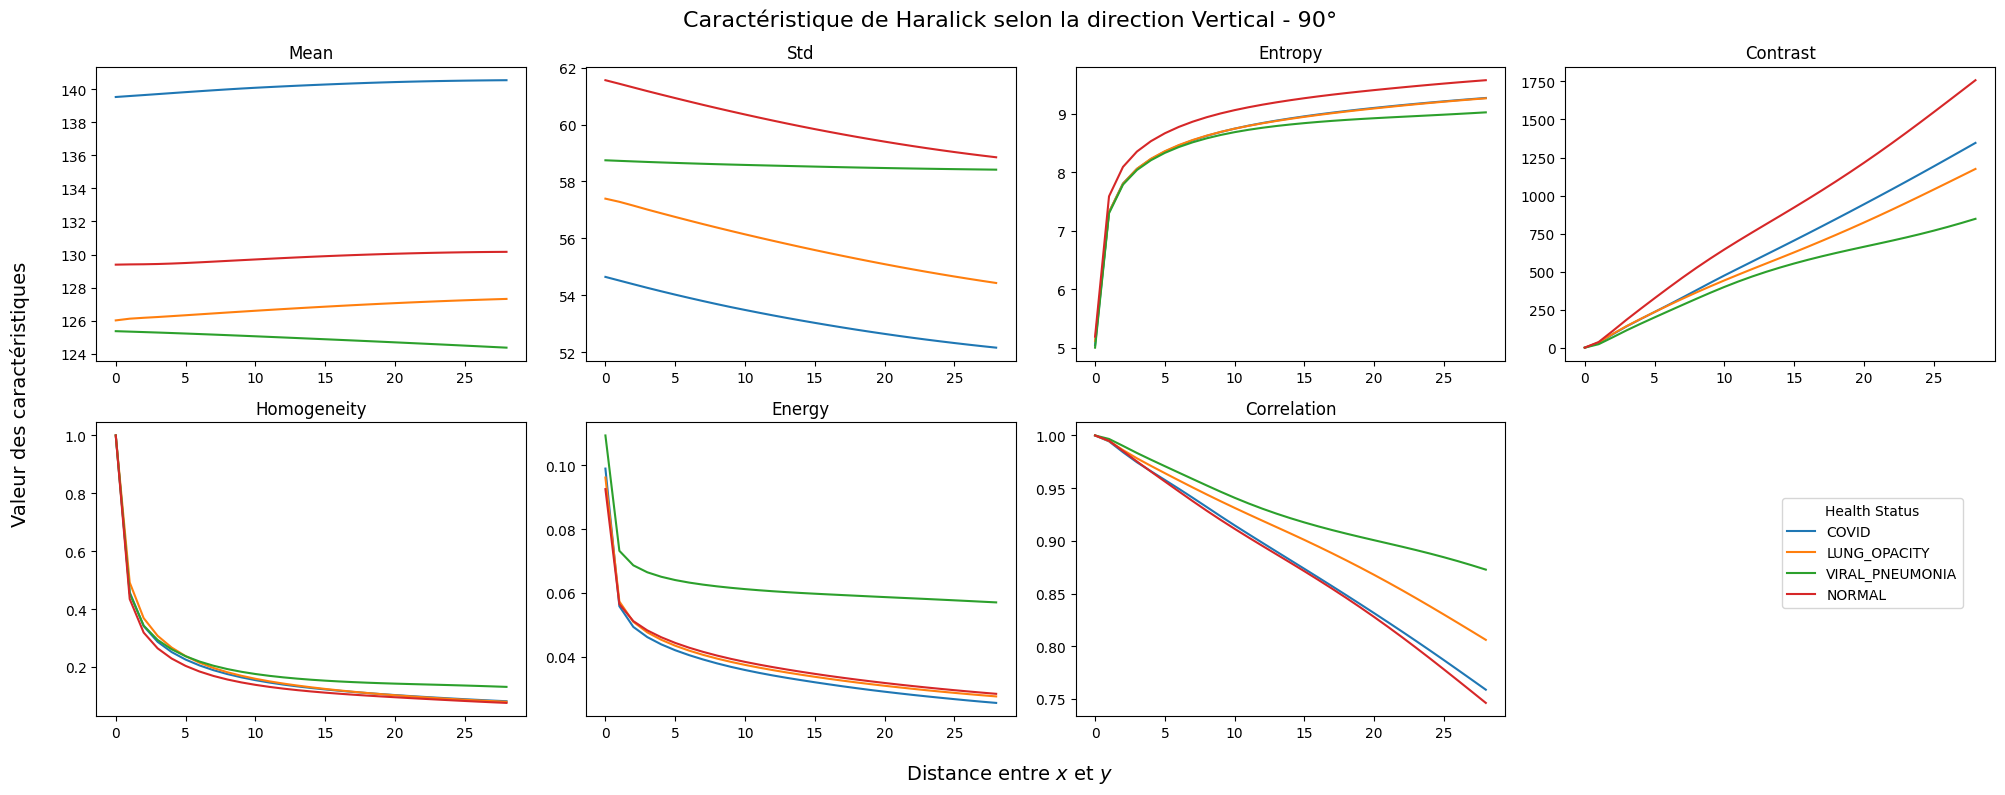

In [ ]:
display_haralick(
    d="vertical", directions=DIRECTIONS, haralick_features=haralick_features, ncols=4
)

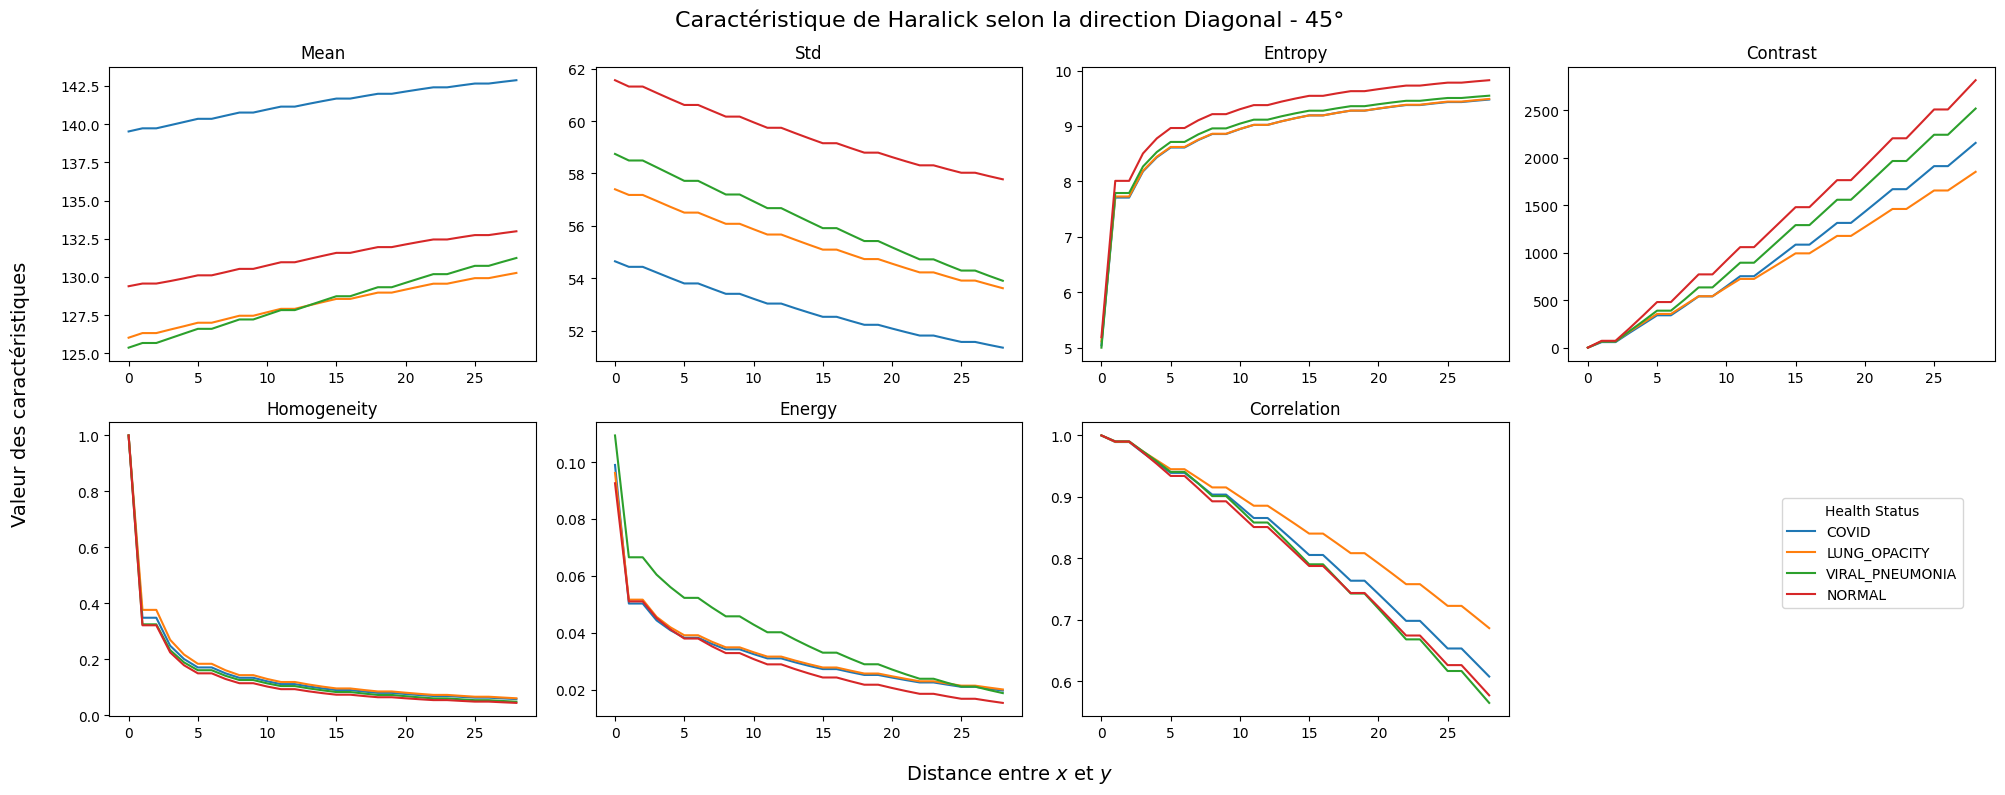

In [ ]:
display_haralick(
    d="diagonal1", directions=DIRECTIONS, haralick_features=haralick_features, ncols=4
)

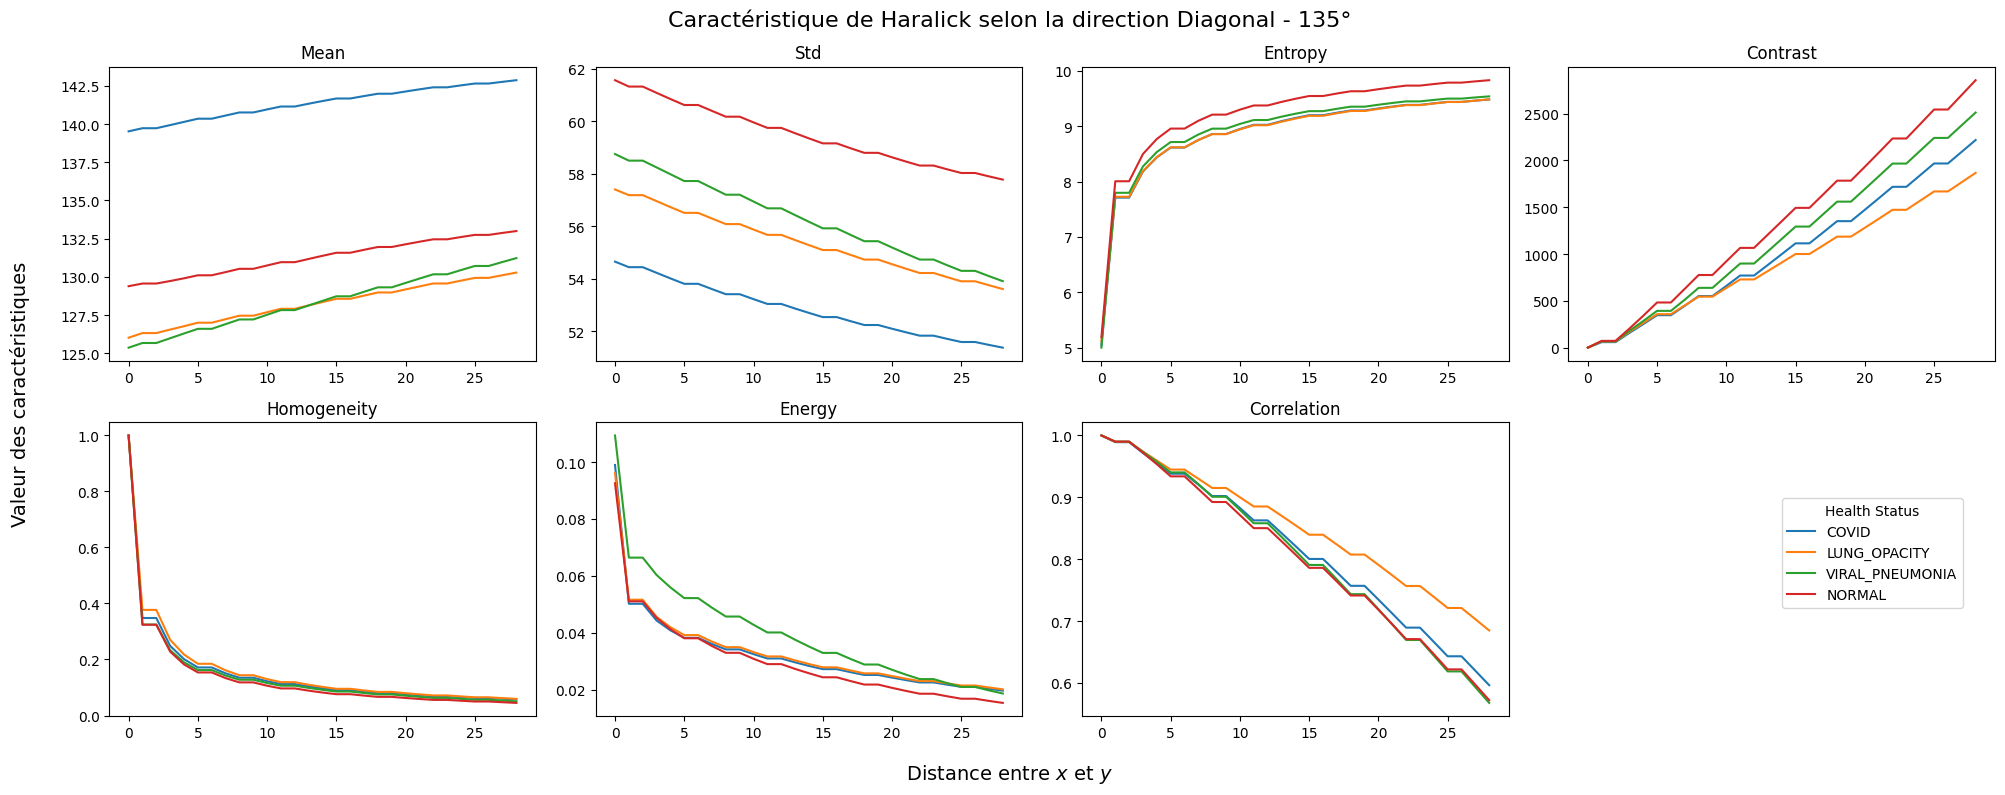

In [ ]:
display_haralick(
    d="diagonal2", directions=DIRECTIONS, haralick_features=haralick_features, ncols=4
)

L'analyse des caractéristiques de haralick des images de notre dataset laisse supposer la présence de microstextures dans ces images. Cette présence de microtextures est marquée par des valeurs d'homogénité et des corrélation entre pixels relativement élévé même au delà de 25 pixels de distances, quel que soit la direction. Ses microtextures seraient semble t il discriminantes d'une catégories à l'autre comme le témoigne es courbes moyennes distinctes à partir d'un seuil d'une catégorie à l'autre pour chaque features.

**NORMAL**: Images les plus claires (en moyenne) avec le plus de variations p/r à la moyennes. Cela suggère que des valeurs de pixels tirent la moyenne vers le haut sans que les images ne paraissent visuellement plus blanches. Les valeurs de constrast confirment en effet ce que nous avons pu observer visuellement.

**VP**: Les valeurs d'énergie montrent les pixels de cette catégorie sont plus concentrées autour de quelques valeurs comparativement aux autres catégories tout en ayant les valeurs de contraste les plus élévées selon l'horizontal. Cela suggère une certaine organisation structurale localisée puisqu'elle tend à disparaître pour des distance > 10 pixels. Ces observations corroborrent les agrégats et la vascularisation observé visulement.

**COVID**: Cette catégorie se distingue par des contrastes plus élévés et des images plus claires comme observé visuelement même si les structures observées apparaissent moins nettement sur les valeurs d'énergie.

**LO**: Contrairement aux autres catégories qui présentent plus ou moins contraste selon un direction, cette catégorie est la moins contrastée dans 3/4 des directions avec l'entropie la plus faible 3 directions / 4 caractéristique d'une distribution redondante des pixels qui corobore l'aspect blanchâtre des images observé visulement.

# REFRENCES



1.   Haralick, RM.; Shanmugam, K., “Textural features for image classification” IEEE Transactions on systems, man, and cybernetics 6 (1973): 610-621. [DOI:10.1109/TSMC.1973.4309314](https://doi.org/10.1109/TSMC.1973.4309314)
2.   

